In [5]:
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import matplotlib.pyplot as plt

In [59]:
class CityDataset(Dataset):

    def __init__(self,image_dir ,transform = None):
        self.image_dir = image_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        full_img = plt.imread(img_path)
        h,w,_ = full_img.shape
        img = full_img[:, :w//2,:]
        mask = full_img[:, w//2:,:]
        return img,mask
    
    def __len__(self):
        return len(self.images)

In [60]:
image_dir = "data/train/"
cd = CityDataset(image_dir)

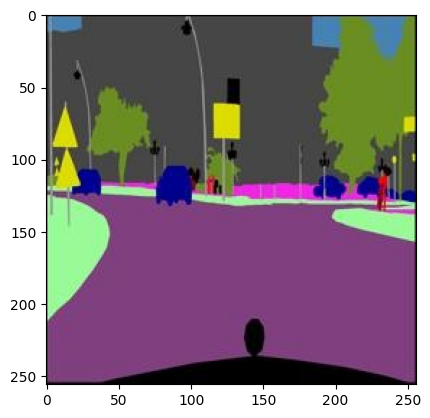

In [62]:
plt.imshow(cd[0][1])
plt.show()

In [65]:
cd[0][1]

array([[[  0,   3,   4],
        [ 12,  21,  28],
        [  0,   2,  11],
        ...,
        [  0,  15,   0],
        [ 21,  36,   3],
        [  0,  10,   0]],

       [[ 19,  34,  39],
        [ 75,  92, 102],
        [ 87, 105, 119],
        ...,
        [ 73,  91,  39],
        [ 83, 101,  61],
        [ 28,  48,  13]],

       [[  8,  35,  46],
        [ 89, 120, 140],
        [121, 153, 176],
        ...,
        [105, 130,  62],
        [111, 134,  80],
        [ 31,  55,   7]],

       ...,

       [[ 40,  16,  38],
        [105,  70, 102],
        [110,  73, 107],
        ...,
        [116,  75, 117],
        [115,  73, 113],
        [ 60,  19,  59]],

       [[ 41,  24,  40],
        [ 82,  54,  77],
        [ 81,  51,  77],
        ...,
        [ 82,  48,  81],
        [ 84,  49,  82],
        [ 41,   7,  40]],

       [[ 10,   0,   9],
        [ 29,   6,  26],
        [ 19,   0,  16],
        ...,
        [ 21,   0,  21],
        [ 43,  12,  43],
        [ 25,   0,  25]]

In [68]:
class convBlock(nn.Module):

    def __init__(self, input_channels,output_channels):
            super(convBlock,self).__init__()
            self.conv1 = nn.Conv2d(input_channels,output_channels,3,1,1)
            self.conv2 = nn.Conv2d(output_channels,output_channels,3,1,1)
            self.BN = nn.BatchNorm2d(output_channels)
            self.relu = nn.ReLU(inplace= True)
    def forward(self, x):
          out = self.relu(self.BN(self.conv1(x)))
          out = self.relu(self.BN(self.conv2(out)))

          return out
          

In [72]:
class encoderBlock(nn.Module):

    def __init__(self, input_channels,features = [64,128,256,512]):
        
        self.blocks = nn.ModuleList()
        self.blocks.append(convBlock(input_channels,64))

        for feature in features:
            self.blocks.append(convBlock(input_channels,feature))
            input_channels = feature

        self.pool = nn.MaxPool2d()
        self.block_output = []           

    def forward(self,x):
        
        for block in self.blocks:

            x = block(x)
            x =self.pool(x)
            self.block_output.append(x)

        return x

In [ ]:
class decoderBlock(nn.Module):

    def __init__(self,input_channels,features = [64,128,256,512]):

        self.blocks = nn.ModuleList()
        
        self.blocks.append(convBlock(input_channels,64))

        features = reversed(features)
        for feature in features:
            
            self.blocks.append(convBlock(feature*2,feature))
            self.blocks.append(nn.ConvTranspose2d(2*feature,feature,2,2))


    def forward(self,x,encoder):
        i = len(encoder.block_output) -1 
        for block in self.blocks:
            concat = torch.cat(encoder.block_output[i],x)
            concat = self.blocks(concat)


            

